In [2]:
!pip install torch torchvision

     -------------------------------------- 198.0/198.0 MB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 889.5 kB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0


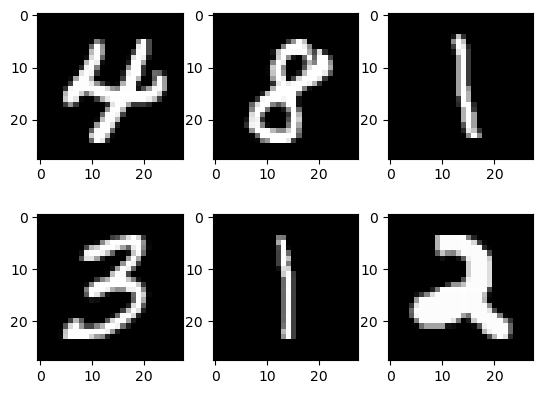

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)
#This type of loading includes data processing that includes:
#Converting to tensors and performing normalization with a mean of 0.5 and a standard deviation of 0.5.
#Also, the data is divided into batches with the possibility to mix the data (shuffle).

# Example: Displaying a few images from the dataset
examples = iter(trainloader)
example_data, example_targets = next(examples)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()


In [9]:
# Size of the full dataset
total_size = len(trainset) + len(testset)
print(f"Total dataset size: {total_size}")

# Size of the training set
train_size = len(trainset)
print(f"Training set size: {train_size}")

# Size of the test set
test_size = len(testset)
print(f"Test set size: {test_size}")


Total dataset size: 70000
Training set size: 60000
Test set size: 10000


Training set label distribution:
Label 5: 5421 samples
Label 0: 5923 samples
Label 4: 5842 samples
Label 1: 6742 samples
Label 9: 5949 samples
Label 2: 5958 samples
Label 3: 6131 samples
Label 6: 5918 samples
Label 7: 6265 samples
Label 8: 5851 samples

Test set label distribution:
Label 7: 1028 samples
Label 2: 1032 samples
Label 1: 1135 samples
Label 0: 980 samples
Label 4: 982 samples
Label 9: 1009 samples
Label 5: 892 samples
Label 6: 958 samples
Label 3: 1010 samples
Label 8: 974 samples


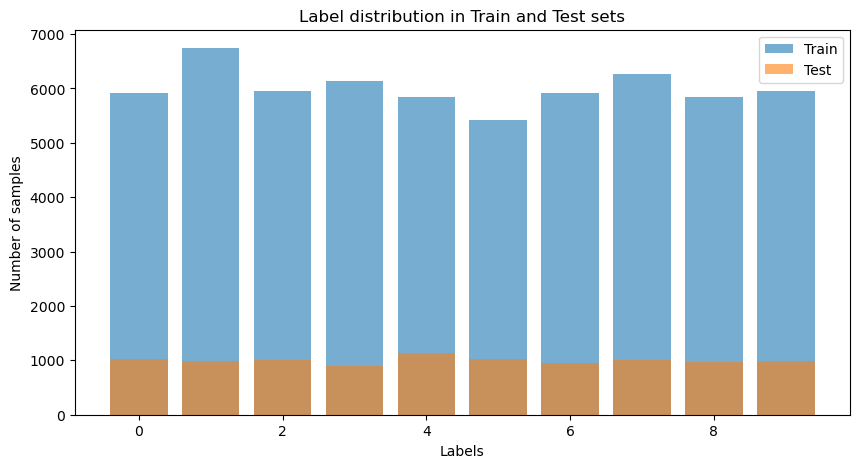

In [9]:
# Count the frequency of each label in the training set
train_labels = [label for _, label in trainset]
train_label_count = Counter(train_labels)

# Count the frequency of each label in the test set
test_labels = [label for _, label in testset]
test_label_count = Counter(test_labels)

# Display the label distribution for training set
print("Training set label distribution:")
for label, count in train_label_count.items():
    print(f"Label {label}: {count} samples")

# Display the label distribution for test set
print("\nTest set label distribution:")
for label, count in test_label_count.items():
    print(f"Label {label}: {count} samples")

# Plotting the distribution
labels = list(train_label_count.keys())
train_counts = list(train_label_count.values())
test_counts = list(test_label_count.values())

plt.figure(figsize=(10, 5))
plt.bar(labels, train_counts, alpha=0.6, label='Train')
plt.bar(labels, test_counts, alpha=0.6, label='Test')
plt.xlabel('Labels')
plt.ylabel('Number of samples')
plt.title('Label distribution in Train and Test sets')
plt.legend()
plt.show()


In [14]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Define a simple neural network with 2 hidden layers
        self.fc1 = nn.Linear(28*28, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 64)     # Second hidden layer
        self.fc3 = nn.Linear(64, 10)      # Output layer
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the network and move it to the GPU if available
model = SimpleNN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


Epoch 1/10, Train Loss: 1.3374, Test Loss: 0.5653, Accuracy: 85.16%
Epoch 2/10, Train Loss: 0.4625, Test Loss: 0.3760, Accuracy: 89.22%
Epoch 3/10, Train Loss: 0.3654, Test Loss: 0.3227, Accuracy: 90.51%
Epoch 4/10, Train Loss: 0.3260, Test Loss: 0.2972, Accuracy: 91.04%
Epoch 5/10, Train Loss: 0.3008, Test Loss: 0.2792, Accuracy: 91.87%
Epoch 6/10, Train Loss: 0.2816, Test Loss: 0.2663, Accuracy: 92.01%
Epoch 7/10, Train Loss: 0.2663, Test Loss: 0.2495, Accuracy: 92.63%
Epoch 8/10, Train Loss: 0.2525, Test Loss: 0.2395, Accuracy: 93.03%
Epoch 9/10, Train Loss: 0.2388, Test Loss: 0.2293, Accuracy: 93.30%
Epoch 10/10, Train Loss: 0.2261, Test Loss: 0.2192, Accuracy: 93.31%


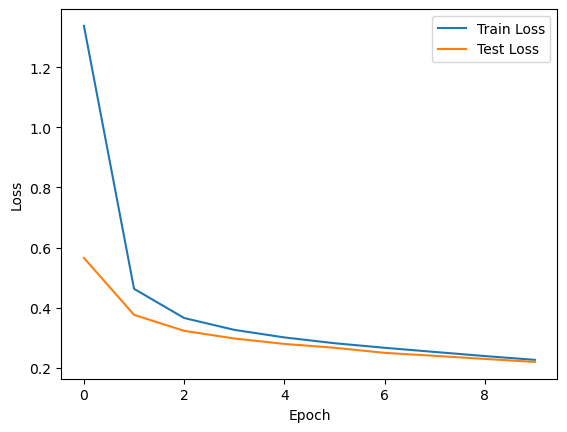

In [12]:
# Training the network
num_epochs = 10
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimize
        
        running_loss += loss.item()
    
    # Calculate average loss for this epoch
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test data
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / len(testloader)
    test_losses.append(avg_test_loss)
    accuracy = 100 * correct / len(testset)
    
#Printing the average loss in each epoch   
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Plotting the loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
num_epochs = 40
train_losses = []
test_losses = []

Epoch 1/40, Train Loss: 0.1682, Test Loss: 0.1657, Accuracy: 95.06%
Epoch 2/40, Train Loss: 0.1575, Test Loss: 0.1540, Accuracy: 95.49%
Epoch 3/40, Train Loss: 0.1470, Test Loss: 0.1487, Accuracy: 95.70%
Epoch 4/40, Train Loss: 0.1382, Test Loss: 0.1428, Accuracy: 95.67%
Epoch 5/40, Train Loss: 0.1299, Test Loss: 0.1375, Accuracy: 95.75%
Epoch 6/40, Train Loss: 0.1228, Test Loss: 0.1346, Accuracy: 95.94%
Epoch 7/40, Train Loss: 0.1164, Test Loss: 0.1225, Accuracy: 96.23%
Epoch 8/40, Train Loss: 0.1101, Test Loss: 0.1193, Accuracy: 96.25%
Epoch 9/40, Train Loss: 0.1051, Test Loss: 0.1137, Accuracy: 96.34%
Epoch 10/40, Train Loss: 0.0996, Test Loss: 0.1134, Accuracy: 96.39%
Epoch 11/40, Train Loss: 0.0952, Test Loss: 0.1107, Accuracy: 96.51%
Epoch 12/40, Train Loss: 0.0907, Test Loss: 0.1082, Accuracy: 96.66%
Epoch 13/40, Train Loss: 0.0866, Test Loss: 0.1111, Accuracy: 96.43%
Epoch 14/40, Train Loss: 0.0831, Test Loss: 0.1038, Accuracy: 96.63%
Epoch 15/40, Train Loss: 0.0794, Test Loss:

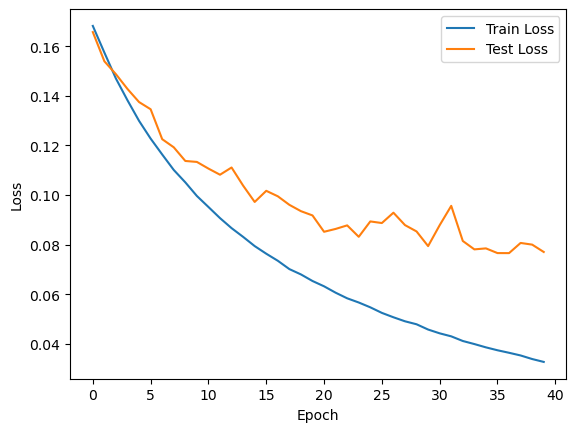

In [19]:
# Training the network

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimize
        
        running_loss += loss.item()
    
    # Calculate average loss for this epoch
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test data
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / len(testloader)
    test_losses.append(avg_test_loss)
    accuracy = 100 * correct / len(testset)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Plotting the loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
# weights:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'Layer: {name} | Weights: {param.data}')

# save
torch.save(model.state_dict(), 'model_weights.pth')

# load
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))


Layer: fc1.weight | Weights: tensor([[ 0.0041, -0.0015, -0.0270,  ...,  0.0348,  0.0095, -0.0296],
        [ 0.0159,  0.0186,  0.0326,  ..., -0.0297, -0.0108,  0.0171],
        [-0.0338, -0.0204,  0.0313,  ...,  0.0123,  0.0189,  0.0285],
        ...,
        [-0.0104,  0.0313, -0.0215,  ..., -0.0273,  0.0292,  0.0176],
        [ 0.0079, -0.0110, -0.0152,  ..., -0.0182, -0.0159,  0.0372],
        [-0.0008,  0.0084,  0.0210,  ..., -0.0087, -0.0075, -0.0200]])
Layer: fc1.bias | Weights: tensor([ 0.0107, -0.0169, -0.0301,  0.0243,  0.0200,  0.0269, -0.0354,  0.0243,
        -0.0114, -0.0130, -0.0003,  0.0228,  0.0138,  0.0220,  0.0093,  0.0333,
        -0.0314,  0.0016,  0.0190, -0.0105, -0.0052,  0.0102, -0.0047,  0.0337,
        -0.0017, -0.0079, -0.0241, -0.0024,  0.0065, -0.0118,  0.0353,  0.0279,
        -0.0202,  0.0278, -0.0281, -0.0338, -0.0131,  0.0015,  0.0106, -0.0307,
         0.0030, -0.0004, -0.0159, -0.0229,  0.0093, -0.0047, -0.0104, -0.0259,
         0.0098, -0.0208,  0.0

<All keys matched successfully>

Architecture: [128, 64], Epoch 1/10, Train Loss: 1.3298, Test Loss: 0.5782, Accuracy: 83.91%
Architecture: [128, 64], Epoch 2/10, Train Loss: 0.4718, Test Loss: 0.3877, Accuracy: 88.93%
Architecture: [128, 64], Epoch 3/10, Train Loss: 0.3735, Test Loss: 0.3330, Accuracy: 90.25%
Architecture: [128, 64], Epoch 4/10, Train Loss: 0.3342, Test Loss: 0.3028, Accuracy: 91.14%
Architecture: [128, 64], Epoch 5/10, Train Loss: 0.3092, Test Loss: 0.2859, Accuracy: 91.80%
Architecture: [128, 64], Epoch 6/10, Train Loss: 0.2891, Test Loss: 0.2701, Accuracy: 92.21%
Architecture: [128, 64], Epoch 7/10, Train Loss: 0.2720, Test Loss: 0.2562, Accuracy: 92.63%
Architecture: [128, 64], Epoch 8/10, Train Loss: 0.2574, Test Loss: 0.2426, Accuracy: 92.93%
Architecture: [128, 64], Epoch 9/10, Train Loss: 0.2441, Test Loss: 0.2333, Accuracy: 93.12%
Architecture: [128, 64], Epoch 10/10, Train Loss: 0.2314, Test Loss: 0.2217, Accuracy: 93.65%
Architecture: [256, 128], Epoch 1/10, Train Loss: 1.8440, Test Loss: 

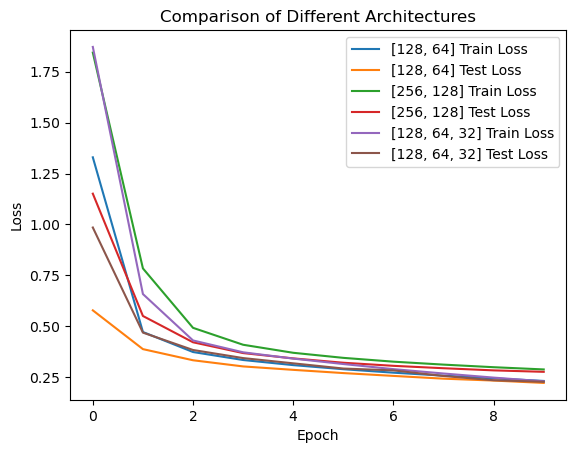

In [15]:
# Experiment with different architectures
architectures = [
    {'layers': [128, 64], 'learning_rate': 0.01},
    {'layers': [256, 128], 'learning_rate': 0.005},
    {'layers': [128, 64, 32], 'learning_rate': 0.01}
]

results = {}

for arch in architectures:
    class ExperimentNN(nn.Module):
        def __init__(self, layers):
            super(ExperimentNN, self).__init__()
            self.layers = nn.ModuleList()
            input_size = 28 * 28
            for layer_size in layers:
                self.layers.append(nn.Linear(input_size, layer_size))
                input_size = layer_size
            self.output = nn.Linear(input_size, 10)

        def forward(self, x):
            x = x.view(-1, 28*28)
            for layer in self.layers:
                x = torch.relu(layer(x))
            x = self.output(x)
            return x

    model = ExperimentNN(arch['layers']).to(device)
    optimizer = optim.SGD(model.parameters(), lr=arch['learning_rate'])

    # Train and evaluate as before
    train_losses, test_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        model.eval()
        test_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        avg_test_loss = test_loss / len(testloader)
        test_losses.append(avg_test_loss)
        accuracy = 100 * correct / len(testset)

        print(f'Architecture: {arch["layers"]}, Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    results[str(arch["layers"])] = (train_losses, test_losses)

# Plotting the results for comparison
for arch, (train_losses, test_losses) in results.items():
    plt.plot(train_losses, label=f'{arch} Train Loss')
    plt.plot(test_losses, label=f'{arch} Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparison of Different Architectures')
plt.show()


In [26]:
num_epochs = 100

train_data, val_data = train_test_split(trainset, test_size=0.2, random_state=42)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=100, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

architectures = [
    {'layers': [128, 64], 'learning_rate': 0.01, 'dropout': 0.5},
    {'layers': [256, 128], 'learning_rate': 0.005, 'dropout': 0.5},
    {'layers': [128, 64, 32], 'learning_rate': 0.01, 'dropout': 0.5},
    {'layers': [512, 256, 128], 'learning_rate': 0.001, 'dropout': 0.5},
    {'layers': [64, 32], 'learning_rate': 0.02, 'dropout': 0.5}
]

results = {}

for arch in architectures:
    class ExperimentNN(nn.Module):
        def __init__(self, layers, dropout):
            super(ExperimentNN, self).__init__()
            self.layers = nn.ModuleList()
            input_size = 28 * 28
            for layer_size in layers:
                self.layers.append(nn.Linear(input_size, layer_size))
                self.layers.append(nn.Dropout(dropout))
                input_size = layer_size
            self.output = nn.Linear(input_size, 10)

        def forward(self, x):
            x = x.view(-1, 28*28)
            for layer in self.layers:
                x = torch.relu(layer(x))
            x = self.output(x)
            return x

    model = ExperimentNN(arch['layers'], arch['dropout']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=arch['learning_rate'])

    # Train and evaluate as before
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(valloader)
        val_losses.append(avg_val_loss)
        accuracy = 100 * correct / len(val_data)

        print(f'Architecture: {arch["layers"]}, Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    results[str(arch["layers"])] = (train_losses, val_losses)

test_losses = {}
for arch in architectures:
    model = ExperimentNN(arch['layers'], arch['dropout']).to(device)
    model.load_state_dict(torch.load(f'model_{str(arch["layers"])}.pth'))
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(testloader)
    test_losses[str(arch["layers"])] = avg_test_loss
    accuracy = 100 * correct / len(testset)
    print(f'Architecture: {arch["layers"]}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

# Plotting the results for comparison
for arch, (train_losses, val_losses) in results.items():
    plt.plot(train_losses, label=f'{arch} Train Loss')
    plt.plot(val_losses, label=f'{arch} Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparison of Different Architectures with Dropout')
plt.show()

# Plotting the test losses
plt.figure()
for arch, test_loss in test_losses.items():
    plt.bar(arch, test_loss, label=f'{arch} Test Loss')

plt.xlabel('Architecture')
plt.ylabel('Test Loss')
plt.legend()
plt.title('Test Loss for Different Architectures')
plt.show()

Architecture: [128, 64], Epoch 1/100, Train Loss: 1.8360, Val Loss: 1.0182, Accuracy: 74.67%
Architecture: [128, 64], Epoch 2/100, Train Loss: 1.0592, Val Loss: 0.6093, Accuracy: 83.87%
Architecture: [128, 64], Epoch 3/100, Train Loss: 0.8087, Val Loss: 0.4808, Accuracy: 87.03%
Architecture: [128, 64], Epoch 4/100, Train Loss: 0.6839, Val Loss: 0.4107, Accuracy: 88.42%
Architecture: [128, 64], Epoch 5/100, Train Loss: 0.6167, Val Loss: 0.3642, Accuracy: 89.78%
Architecture: [128, 64], Epoch 6/100, Train Loss: 0.5646, Val Loss: 0.3366, Accuracy: 90.39%
Architecture: [128, 64], Epoch 7/100, Train Loss: 0.5327, Val Loss: 0.3163, Accuracy: 90.91%
Architecture: [128, 64], Epoch 8/100, Train Loss: 0.4990, Val Loss: 0.2940, Accuracy: 91.47%
Architecture: [128, 64], Epoch 9/100, Train Loss: 0.4725, Val Loss: 0.2821, Accuracy: 91.86%
Architecture: [128, 64], Epoch 10/100, Train Loss: 0.4509, Val Loss: 0.2729, Accuracy: 92.08%
Architecture: [128, 64], Epoch 11/100, Train Loss: 0.4305, Val Loss: 

Architecture: [128, 64], Epoch 89/100, Train Loss: 0.1738, Val Loss: 0.1124, Accuracy: 96.65%
Architecture: [128, 64], Epoch 90/100, Train Loss: 0.1775, Val Loss: 0.1111, Accuracy: 96.82%
Architecture: [128, 64], Epoch 91/100, Train Loss: 0.1723, Val Loss: 0.1132, Accuracy: 96.75%
Architecture: [128, 64], Epoch 92/100, Train Loss: 0.1747, Val Loss: 0.1117, Accuracy: 96.80%
Architecture: [128, 64], Epoch 93/100, Train Loss: 0.1705, Val Loss: 0.1115, Accuracy: 96.80%
Architecture: [128, 64], Epoch 94/100, Train Loss: 0.1729, Val Loss: 0.1097, Accuracy: 96.80%
Architecture: [128, 64], Epoch 95/100, Train Loss: 0.1669, Val Loss: 0.1102, Accuracy: 96.87%
Architecture: [128, 64], Epoch 96/100, Train Loss: 0.1722, Val Loss: 0.1115, Accuracy: 96.81%
Architecture: [128, 64], Epoch 97/100, Train Loss: 0.1688, Val Loss: 0.1115, Accuracy: 96.77%
Architecture: [128, 64], Epoch 98/100, Train Loss: 0.1681, Val Loss: 0.1112, Accuracy: 96.89%
Architecture: [128, 64], Epoch 99/100, Train Loss: 0.1642, V

Architecture: [256, 128], Epoch 76/100, Train Loss: 0.1667, Val Loss: 0.1139, Accuracy: 96.50%
Architecture: [256, 128], Epoch 77/100, Train Loss: 0.1678, Val Loss: 0.1137, Accuracy: 96.51%
Architecture: [256, 128], Epoch 78/100, Train Loss: 0.1638, Val Loss: 0.1136, Accuracy: 96.49%
Architecture: [256, 128], Epoch 79/100, Train Loss: 0.1610, Val Loss: 0.1114, Accuracy: 96.60%
Architecture: [256, 128], Epoch 80/100, Train Loss: 0.1607, Val Loss: 0.1105, Accuracy: 96.62%
Architecture: [256, 128], Epoch 81/100, Train Loss: 0.1564, Val Loss: 0.1111, Accuracy: 96.64%
Architecture: [256, 128], Epoch 82/100, Train Loss: 0.1588, Val Loss: 0.1108, Accuracy: 96.69%
Architecture: [256, 128], Epoch 83/100, Train Loss: 0.1576, Val Loss: 0.1107, Accuracy: 96.61%
Architecture: [256, 128], Epoch 84/100, Train Loss: 0.1575, Val Loss: 0.1095, Accuracy: 96.64%
Architecture: [256, 128], Epoch 85/100, Train Loss: 0.1537, Val Loss: 0.1101, Accuracy: 96.58%
Architecture: [256, 128], Epoch 86/100, Train Loss

Architecture: [128, 64, 32], Epoch 61/100, Train Loss: 0.3113, Val Loss: 0.1596, Accuracy: 95.87%
Architecture: [128, 64, 32], Epoch 62/100, Train Loss: 0.3138, Val Loss: 0.1577, Accuracy: 96.04%
Architecture: [128, 64, 32], Epoch 63/100, Train Loss: 0.3084, Val Loss: 0.1543, Accuracy: 96.07%
Architecture: [128, 64, 32], Epoch 64/100, Train Loss: 0.3070, Val Loss: 0.1547, Accuracy: 96.02%
Architecture: [128, 64, 32], Epoch 65/100, Train Loss: 0.3017, Val Loss: 0.1530, Accuracy: 96.22%
Architecture: [128, 64, 32], Epoch 66/100, Train Loss: 0.3027, Val Loss: 0.1535, Accuracy: 96.15%
Architecture: [128, 64, 32], Epoch 67/100, Train Loss: 0.2995, Val Loss: 0.1499, Accuracy: 96.12%
Architecture: [128, 64, 32], Epoch 68/100, Train Loss: 0.2964, Val Loss: 0.1593, Accuracy: 95.75%
Architecture: [128, 64, 32], Epoch 69/100, Train Loss: 0.2995, Val Loss: 0.1472, Accuracy: 96.02%
Architecture: [128, 64, 32], Epoch 70/100, Train Loss: 0.2935, Val Loss: 0.1494, Accuracy: 96.15%
Architecture: [128, 

Architecture: [512, 256, 128], Epoch 44/100, Train Loss: 0.5858, Val Loss: 0.4006, Accuracy: 88.42%
Architecture: [512, 256, 128], Epoch 45/100, Train Loss: 0.5764, Val Loss: 0.3933, Accuracy: 88.69%
Architecture: [512, 256, 128], Epoch 46/100, Train Loss: 0.5699, Val Loss: 0.3881, Accuracy: 88.81%
Architecture: [512, 256, 128], Epoch 47/100, Train Loss: 0.5622, Val Loss: 0.3825, Accuracy: 89.00%
Architecture: [512, 256, 128], Epoch 48/100, Train Loss: 0.5531, Val Loss: 0.3770, Accuracy: 89.08%
Architecture: [512, 256, 128], Epoch 49/100, Train Loss: 0.5483, Val Loss: 0.3717, Accuracy: 89.30%
Architecture: [512, 256, 128], Epoch 50/100, Train Loss: 0.5366, Val Loss: 0.3668, Accuracy: 89.50%
Architecture: [512, 256, 128], Epoch 51/100, Train Loss: 0.5326, Val Loss: 0.3617, Accuracy: 89.56%
Architecture: [512, 256, 128], Epoch 52/100, Train Loss: 0.5262, Val Loss: 0.3580, Accuracy: 89.76%
Architecture: [512, 256, 128], Epoch 53/100, Train Loss: 0.5169, Val Loss: 0.3531, Accuracy: 89.79%


Architecture: [64, 32], Epoch 28/100, Train Loss: 0.4294, Val Loss: 0.1976, Accuracy: 94.28%
Architecture: [64, 32], Epoch 29/100, Train Loss: 0.4247, Val Loss: 0.2045, Accuracy: 94.11%
Architecture: [64, 32], Epoch 30/100, Train Loss: 0.4215, Val Loss: 0.1925, Accuracy: 94.41%
Architecture: [64, 32], Epoch 31/100, Train Loss: 0.4186, Val Loss: 0.1939, Accuracy: 94.27%
Architecture: [64, 32], Epoch 32/100, Train Loss: 0.4139, Val Loss: 0.1950, Accuracy: 94.23%
Architecture: [64, 32], Epoch 33/100, Train Loss: 0.4063, Val Loss: 0.1933, Accuracy: 94.34%
Architecture: [64, 32], Epoch 34/100, Train Loss: 0.4128, Val Loss: 0.1982, Accuracy: 94.31%
Architecture: [64, 32], Epoch 35/100, Train Loss: 0.4038, Val Loss: 0.1945, Accuracy: 94.38%
Architecture: [64, 32], Epoch 36/100, Train Loss: 0.4006, Val Loss: 0.1909, Accuracy: 94.48%
Architecture: [64, 32], Epoch 37/100, Train Loss: 0.3956, Val Loss: 0.1904, Accuracy: 94.72%
Architecture: [64, 32], Epoch 38/100, Train Loss: 0.3955, Val Loss: 0.

C:\Users\itayg\AppData\Local\Temp\ipykernel_7672\1214420652.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'model_{str(arch["layers"]

FileNotFoundError: [Errno 2] No such file or directory: 'model_[128, 64].pth'

Architecture: [512, 256, 128], Epoch 1/100, Train Loss: 2.3050, Val Loss: 2.2945, Accuracy: 14.38%
Architecture: [512, 256, 128], Epoch 2/100, Train Loss: 2.2955, Val Loss: 2.2838, Accuracy: 17.27%
Architecture: [512, 256, 128], Epoch 3/100, Train Loss: 2.2866, Val Loss: 2.2713, Accuracy: 17.13%
Architecture: [512, 256, 128], Epoch 4/100, Train Loss: 2.2755, Val Loss: 2.2551, Accuracy: 18.18%
Architecture: [512, 256, 128], Epoch 5/100, Train Loss: 2.2622, Val Loss: 2.2336, Accuracy: 21.57%
Architecture: [512, 256, 128], Epoch 6/100, Train Loss: 2.2444, Val Loss: 2.2050, Accuracy: 26.93%
Architecture: [512, 256, 128], Epoch 7/100, Train Loss: 2.2196, Val Loss: 2.1652, Accuracy: 35.15%
Architecture: [512, 256, 128], Epoch 8/100, Train Loss: 2.1855, Val Loss: 2.1086, Accuracy: 42.69%
Architecture: [512, 256, 128], Epoch 9/100, Train Loss: 2.1363, Val Loss: 2.0274, Accuracy: 46.06%
Architecture: [512, 256, 128], Epoch 10/100, Train Loss: 2.0683, Val Loss: 1.9167, Accuracy: 49.73%
Architect

Architecture: [512, 256, 128], Epoch 84/100, Train Loss: 0.3902, Val Loss: 0.2608, Accuracy: 92.33%
Architecture: [512, 256, 128], Epoch 85/100, Train Loss: 0.3857, Val Loss: 0.2593, Accuracy: 92.23%
Architecture: [512, 256, 128], Epoch 86/100, Train Loss: 0.3821, Val Loss: 0.2567, Accuracy: 92.42%
Architecture: [512, 256, 128], Epoch 87/100, Train Loss: 0.3785, Val Loss: 0.2538, Accuracy: 92.53%
Architecture: [512, 256, 128], Epoch 88/100, Train Loss: 0.3763, Val Loss: 0.2529, Accuracy: 92.58%
Architecture: [512, 256, 128], Epoch 89/100, Train Loss: 0.3765, Val Loss: 0.2507, Accuracy: 92.60%
Architecture: [512, 256, 128], Epoch 90/100, Train Loss: 0.3676, Val Loss: 0.2496, Accuracy: 92.67%
Architecture: [512, 256, 128], Epoch 91/100, Train Loss: 0.3706, Val Loss: 0.2471, Accuracy: 92.70%
Architecture: [512, 256, 128], Epoch 92/100, Train Loss: 0.3656, Val Loss: 0.2450, Accuracy: 92.75%
Architecture: [512, 256, 128], Epoch 93/100, Train Loss: 0.3619, Val Loss: 0.2435, Accuracy: 92.81%


Architecture: [256, 128], Epoch 70/100, Train Loss: 0.1208, Val Loss: 0.0923, Accuracy: 97.22%
Architecture: [256, 128], Epoch 71/100, Train Loss: 0.1201, Val Loss: 0.0909, Accuracy: 97.21%
Architecture: [256, 128], Epoch 72/100, Train Loss: 0.1173, Val Loss: 0.0918, Accuracy: 97.17%
Architecture: [256, 128], Epoch 73/100, Train Loss: 0.1172, Val Loss: 0.0899, Accuracy: 97.27%
Architecture: [256, 128], Epoch 74/100, Train Loss: 0.1156, Val Loss: 0.0884, Accuracy: 97.37%
Architecture: [256, 128], Epoch 75/100, Train Loss: 0.1157, Val Loss: 0.0878, Accuracy: 97.28%
Architecture: [256, 128], Epoch 76/100, Train Loss: 0.1137, Val Loss: 0.0873, Accuracy: 97.35%
Architecture: [256, 128], Epoch 77/100, Train Loss: 0.1137, Val Loss: 0.0898, Accuracy: 97.29%
Architecture: [256, 128], Epoch 78/100, Train Loss: 0.1120, Val Loss: 0.0887, Accuracy: 97.32%
Architecture: [256, 128], Epoch 79/100, Train Loss: 0.1119, Val Loss: 0.0864, Accuracy: 97.33%
Architecture: [256, 128], Epoch 80/100, Train Loss

Architecture: [128, 64, 32], Epoch 55/100, Train Loss: 0.3183, Val Loss: 0.1466, Accuracy: 95.93%
Architecture: [128, 64, 32], Epoch 56/100, Train Loss: 0.3126, Val Loss: 0.1497, Accuracy: 95.96%
Architecture: [128, 64, 32], Epoch 57/100, Train Loss: 0.3143, Val Loss: 0.1454, Accuracy: 96.05%
Architecture: [128, 64, 32], Epoch 58/100, Train Loss: 0.3101, Val Loss: 0.1506, Accuracy: 95.99%
Architecture: [128, 64, 32], Epoch 59/100, Train Loss: 0.3039, Val Loss: 0.1480, Accuracy: 96.23%
Architecture: [128, 64, 32], Epoch 60/100, Train Loss: 0.3107, Val Loss: 0.1418, Accuracy: 96.18%
Architecture: [128, 64, 32], Epoch 61/100, Train Loss: 0.2975, Val Loss: 0.1448, Accuracy: 96.07%
Architecture: [128, 64, 32], Epoch 62/100, Train Loss: 0.3029, Val Loss: 0.1402, Accuracy: 96.25%
Architecture: [128, 64, 32], Epoch 63/100, Train Loss: 0.3006, Val Loss: 0.1382, Accuracy: 96.23%
Architecture: [128, 64, 32], Epoch 64/100, Train Loss: 0.3021, Val Loss: 0.1372, Accuracy: 96.17%
Architecture: [128, 

Architecture: [128, 64], Epoch 41/100, Train Loss: 0.2592, Val Loss: 0.1452, Accuracy: 95.58%
Architecture: [128, 64], Epoch 42/100, Train Loss: 0.2579, Val Loss: 0.1451, Accuracy: 95.71%
Architecture: [128, 64], Epoch 43/100, Train Loss: 0.2525, Val Loss: 0.1408, Accuracy: 95.86%
Architecture: [128, 64], Epoch 44/100, Train Loss: 0.2503, Val Loss: 0.1411, Accuracy: 95.78%
Architecture: [128, 64], Epoch 45/100, Train Loss: 0.2500, Val Loss: 0.1376, Accuracy: 95.83%
Architecture: [128, 64], Epoch 46/100, Train Loss: 0.2469, Val Loss: 0.1372, Accuracy: 95.98%
Architecture: [128, 64], Epoch 47/100, Train Loss: 0.2456, Val Loss: 0.1395, Accuracy: 95.83%
Architecture: [128, 64], Epoch 48/100, Train Loss: 0.2440, Val Loss: 0.1351, Accuracy: 96.00%
Architecture: [128, 64], Epoch 49/100, Train Loss: 0.2435, Val Loss: 0.1342, Accuracy: 95.88%
Architecture: [128, 64], Epoch 50/100, Train Loss: 0.2368, Val Loss: 0.1363, Accuracy: 95.83%
Architecture: [128, 64], Epoch 51/100, Train Loss: 0.2391, V

Architecture: [64, 32], Epoch 29/100, Train Loss: 0.4772, Val Loss: 0.2303, Accuracy: 93.09%
Architecture: [64, 32], Epoch 30/100, Train Loss: 0.4691, Val Loss: 0.2204, Accuracy: 93.55%
Architecture: [64, 32], Epoch 31/100, Train Loss: 0.4670, Val Loss: 0.2250, Accuracy: 93.77%
Architecture: [64, 32], Epoch 32/100, Train Loss: 0.4585, Val Loss: 0.2153, Accuracy: 93.65%
Architecture: [64, 32], Epoch 33/100, Train Loss: 0.4578, Val Loss: 0.2135, Accuracy: 94.03%
Architecture: [64, 32], Epoch 34/100, Train Loss: 0.4547, Val Loss: 0.2129, Accuracy: 93.84%
Architecture: [64, 32], Epoch 35/100, Train Loss: 0.4504, Val Loss: 0.2116, Accuracy: 93.68%
Architecture: [64, 32], Epoch 36/100, Train Loss: 0.4431, Val Loss: 0.2072, Accuracy: 93.83%
Architecture: [64, 32], Epoch 37/100, Train Loss: 0.4433, Val Loss: 0.2057, Accuracy: 94.17%
Architecture: [64, 32], Epoch 38/100, Train Loss: 0.4358, Val Loss: 0.1999, Accuracy: 94.17%
Architecture: [64, 32], Epoch 39/100, Train Loss: 0.4291, Val Loss: 0.

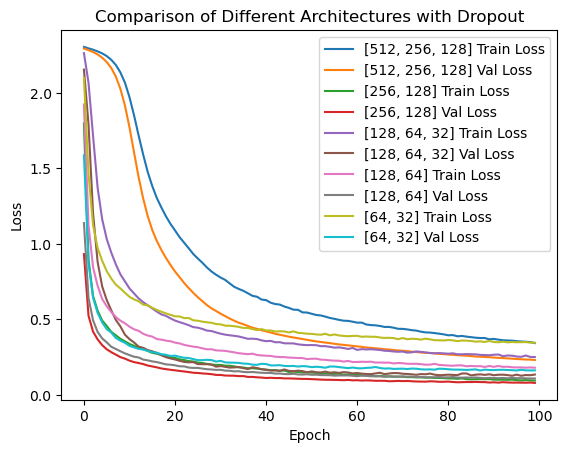

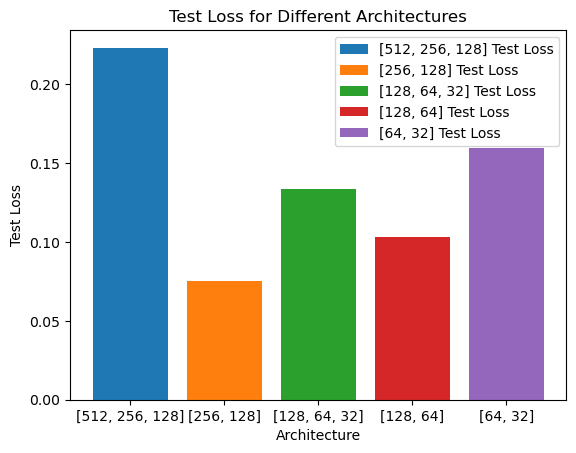

In [27]:
architectures = [
    {'layers': [512, 256, 128], 'learning_rate': 0.001, 'dropout': 0.5},
    {'layers': [256, 128], 'learning_rate': 0.01, 'dropout': 0.5},
    {'layers': [128, 64, 32], 'learning_rate': 0.01, 'dropout': 0.5},
    {'layers': [128, 64], 'learning_rate': 0.01, 'dropout': 0.5},
    {'layers': [64, 32], 'learning_rate': 0.01, 'dropout': 0.5}
]

results = {}

for arch in architectures:
    class ExperimentNN(nn.Module):
        def __init__(self, layers, dropout):
            super(ExperimentNN, self).__init__()
            self.layers = nn.ModuleList()
            input_size = 28 * 28
            for layer_size in layers:
                self.layers.append(nn.Linear(input_size, layer_size))
                self.layers.append(nn.Dropout(dropout))
                input_size = layer_size
            self.output = nn.Linear(input_size, 10)

        def forward(self, x):
            x = x.view(-1, 28*28)
            for layer in self.layers:
                x = torch.relu(layer(x))
            x = self.output(x)
            return x

    model = ExperimentNN(arch['layers'], arch['dropout']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=arch['learning_rate'])

    # Train and evaluate as before
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(valloader)
        val_losses.append(avg_val_loss)
        accuracy = 100 * correct / len(val_data)

        print(f'Architecture: {arch["layers"]}, Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    # save
    torch.save(model.state_dict(), f'model_{str(arch["layers"])}.pth')
    results[str(arch["layers"])] = (train_losses, val_losses)

# Check on the test data after the end of the training
test_losses = {}
for arch in architectures:
    model = ExperimentNN(arch['layers'], arch['dropout']).to(device)
    model.load_state_dict(torch.load(f'model_{str(arch["layers"])}.pth', weights_only=True))
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(testloader)
    test_losses[str(arch["layers"])] = avg_test_loss
    accuracy = 100 * correct / len(testset)
    print(f'Architecture: {arch["layers"]}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

# Plotting the results for comparison
for arch, (train_losses, val_losses) in results.items():
    plt.plot(train_losses, label=f'{arch} Train Loss')
    plt.plot(val_losses, label=f'{arch} Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparison of Different Architectures with Dropout')
plt.show()

# Plotting the test losses
plt.figure()
for arch, test_loss in test_losses.items():
    plt.bar(arch, test_loss, label=f'{arch} Test Loss')

plt.xlabel('Architecture')
plt.ylabel('Test Loss')
plt.legend()
plt.title('Test Loss for Different Architectures')
plt.show()


Architecture: [256, 128, 64, 32], Epoch 1/100, Train Loss: 2.3019, Val Loss: 2.2924, Accuracy: 18.47%
Architecture: [256, 128, 64, 32], Epoch 2/100, Train Loss: 2.2854, Val Loss: 2.2483, Accuracy: 26.77%
Architecture: [256, 128, 64, 32], Epoch 3/100, Train Loss: 2.1982, Val Loss: 1.9886, Accuracy: 29.16%
Architecture: [256, 128, 64, 32], Epoch 4/100, Train Loss: 1.9431, Val Loss: 1.5640, Accuracy: 45.88%
Architecture: [256, 128, 64, 32], Epoch 5/100, Train Loss: 1.6428, Val Loss: 1.2019, Accuracy: 63.26%
Architecture: [256, 128, 64, 32], Epoch 6/100, Train Loss: 1.4089, Val Loss: 0.9902, Accuracy: 70.16%
Architecture: [256, 128, 64, 32], Epoch 7/100, Train Loss: 1.2425, Val Loss: 0.8673, Accuracy: 74.23%
Architecture: [256, 128, 64, 32], Epoch 8/100, Train Loss: 1.1308, Val Loss: 0.7631, Accuracy: 78.88%
Architecture: [256, 128, 64, 32], Epoch 9/100, Train Loss: 1.0433, Val Loss: 0.6888, Accuracy: 80.05%
Architecture: [256, 128, 64, 32], Epoch 10/100, Train Loss: 0.9756, Val Loss: 0.62

Architecture: [256, 128, 64, 32], Epoch 81/100, Train Loss: 0.2268, Val Loss: 0.1560, Accuracy: 96.99%
Architecture: [256, 128, 64, 32], Epoch 82/100, Train Loss: 0.2286, Val Loss: 0.1581, Accuracy: 96.83%
Architecture: [256, 128, 64, 32], Epoch 83/100, Train Loss: 0.2289, Val Loss: 0.1549, Accuracy: 96.78%
Architecture: [256, 128, 64, 32], Epoch 84/100, Train Loss: 0.2268, Val Loss: 0.1621, Accuracy: 96.78%
Architecture: [256, 128, 64, 32], Epoch 85/100, Train Loss: 0.2256, Val Loss: 0.1537, Accuracy: 96.93%
Architecture: [256, 128, 64, 32], Epoch 86/100, Train Loss: 0.2204, Val Loss: 0.1452, Accuracy: 96.86%
Architecture: [256, 128, 64, 32], Epoch 87/100, Train Loss: 0.2209, Val Loss: 0.1592, Accuracy: 96.69%
Architecture: [256, 128, 64, 32], Epoch 88/100, Train Loss: 0.2147, Val Loss: 0.1601, Accuracy: 96.78%
Architecture: [256, 128, 64, 32], Epoch 89/100, Train Loss: 0.2151, Val Loss: 0.1505, Accuracy: 96.91%
Architecture: [256, 128, 64, 32], Epoch 90/100, Train Loss: 0.2181, Val L

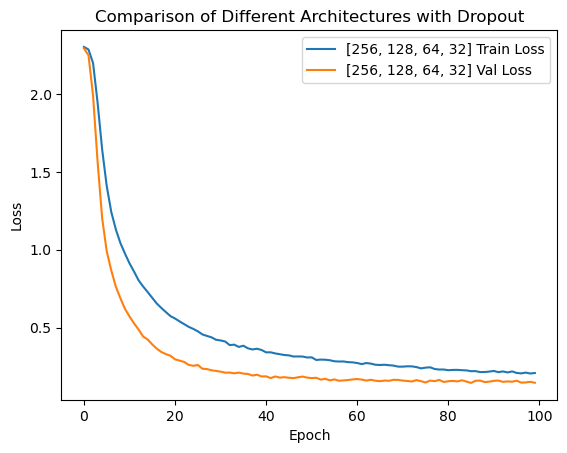

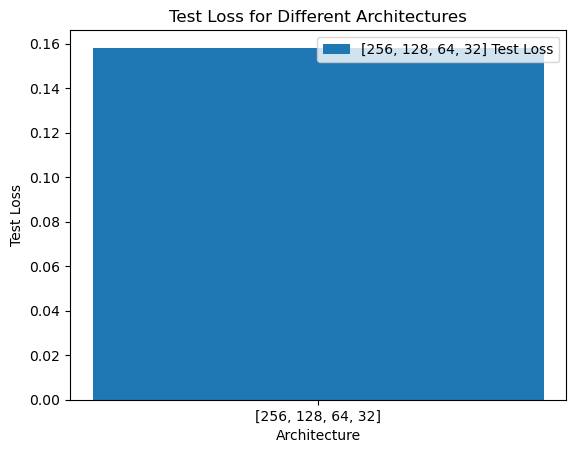

In [28]:
architectures = [
    {'layers': [256, 128, 64, 32], 'learning_rate': 0.01, 'dropout': 0.5}
]

results = {}

for arch in architectures:
    class ExperimentNN(nn.Module):
        def __init__(self, layers, dropout):
            super(ExperimentNN, self).__init__()
            self.layers = nn.ModuleList()
            input_size = 28 * 28
            for layer_size in layers:
                self.layers.append(nn.Linear(input_size, layer_size))
                self.layers.append(nn.Dropout(dropout))
                input_size = layer_size
            self.output = nn.Linear(input_size, 10)

        def forward(self, x):
            x = x.view(-1, 28*28)
            for layer in self.layers:
                x = torch.relu(layer(x))
            x = self.output(x)
            return x

    model = ExperimentNN(arch['layers'], arch['dropout']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=arch['learning_rate'])

    # Train and evaluate as before
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(valloader)
        val_losses.append(avg_val_loss)
        accuracy = 100 * correct / len(val_data)

        print(f'Architecture: {arch["layers"]}, Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    # save
    torch.save(model.state_dict(), f'model_{str(arch["layers"])}.pth')
    results[str(arch["layers"])] = (train_losses, val_losses)

# Check on the test data after the end of the training
test_losses = {}
for arch in architectures:
    model = ExperimentNN(arch['layers'], arch['dropout']).to(device)
    model.load_state_dict(torch.load(f'model_{str(arch["layers"])}.pth', weights_only=True))
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(testloader)
    test_losses[str(arch["layers"])] = avg_test_loss
    accuracy = 100 * correct / len(testset)
    print(f'Architecture: {arch["layers"]}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

# Plotting the results for comparison
for arch, (train_losses, val_losses) in results.items():
    plt.plot(train_losses, label=f'{arch} Train Loss')
    plt.plot(val_losses, label=f'{arch} Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparison of Different Architectures with Dropout')
plt.show()

# Plotting the test losses
plt.figure()
for arch, test_loss in test_losses.items():
    plt.bar(arch, test_loss, label=f'{arch} Test Loss')

plt.xlabel('Architecture')
plt.ylabel('Test Loss')
plt.legend()
plt.title('Test Loss for Different Architectures')
plt.show()


In [ ]:
# Experiment with different architectures
num_epochs = 500


architectures = [
    {'layers': [256, 128], 'learning_rate': 0.01, 'dropout': 0.5},
    {'layers': [256, 128], 'learning_rate': 0.01, 'dropout': 0.0}
]

results = {}

for arch in architectures:
    class ExperimentNN(nn.Module):
        def __init__(self, layers):
            super(ExperimentNN, self).__init__()
            self.layers = nn.ModuleList()
            input_size = 28 * 28
            for layer_size in layers:
                self.layers.append(nn.Linear(input_size, layer_size))
                input_size = layer_size
            self.output = nn.Linear(input_size, 10)

        def forward(self, x):
            x = x.view(-1, 28*28)
            for layer in self.layers:
                x = torch.relu(layer(x))
            x = self.output(x)
            return x

    model = ExperimentNN(arch['layers']).to(device)
    optimizer = optim.SGD(model.parameters(), lr=arch['learning_rate'])

    # Train and evaluate as before
    train_losses, test_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        model.eval()
        test_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        avg_test_loss = test_loss / len(testloader)
        test_losses.append(avg_test_loss)
        accuracy = 100 * correct / len(testset)

        print(f'Architecture: {arch["layers"]}, Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    results[str(arch["layers"])] = (train_losses, test_losses)

# Plotting the results for comparison
for arch, (train_losses, test_losses) in results.items():
    plt.plot(train_losses, label=f'{arch} Train Loss')
    plt.plot(test_losses, label=f'{arch} Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparison of Different Architectures')
plt.show()


Architecture: [256, 128], Epoch 1/10000, Train Loss: 1.2906, Test Loss: 0.5269, Accuracy: 86.76%
Architecture: [256, 128], Epoch 2/10000, Train Loss: 0.4452, Test Loss: 0.3676, Accuracy: 89.68%
Architecture: [256, 128], Epoch 3/10000, Train Loss: 0.3598, Test Loss: 0.3244, Accuracy: 90.35%
Architecture: [256, 128], Epoch 4/10000, Train Loss: 0.3239, Test Loss: 0.2994, Accuracy: 90.98%
Architecture: [256, 128], Epoch 5/10000, Train Loss: 0.2997, Test Loss: 0.2775, Accuracy: 91.93%
Architecture: [256, 128], Epoch 6/10000, Train Loss: 0.2815, Test Loss: 0.2617, Accuracy: 92.31%
Architecture: [256, 128], Epoch 7/10000, Train Loss: 0.2651, Test Loss: 0.2549, Accuracy: 92.46%
Architecture: [256, 128], Epoch 8/10000, Train Loss: 0.2503, Test Loss: 0.2340, Accuracy: 93.34%
Architecture: [256, 128], Epoch 9/10000, Train Loss: 0.2363, Test Loss: 0.2253, Accuracy: 93.64%
Architecture: [256, 128], Epoch 10/10000, Train Loss: 0.2237, Test Loss: 0.2163, Accuracy: 93.90%
Architecture: [256, 128], Epo

Architecture: [256, 128], Epoch 85/10000, Train Loss: 0.0193, Test Loss: 0.0688, Accuracy: 97.84%
Architecture: [256, 128], Epoch 86/10000, Train Loss: 0.0187, Test Loss: 0.0692, Accuracy: 97.88%
Architecture: [256, 128], Epoch 87/10000, Train Loss: 0.0182, Test Loss: 0.0694, Accuracy: 97.78%
Architecture: [256, 128], Epoch 88/10000, Train Loss: 0.0179, Test Loss: 0.0715, Accuracy: 97.71%
Architecture: [256, 128], Epoch 89/10000, Train Loss: 0.0173, Test Loss: 0.0691, Accuracy: 97.82%
Architecture: [256, 128], Epoch 90/10000, Train Loss: 0.0170, Test Loss: 0.0687, Accuracy: 97.86%
Architecture: [256, 128], Epoch 91/10000, Train Loss: 0.0165, Test Loss: 0.0679, Accuracy: 97.80%
Architecture: [256, 128], Epoch 92/10000, Train Loss: 0.0161, Test Loss: 0.0703, Accuracy: 97.83%
Architecture: [256, 128], Epoch 93/10000, Train Loss: 0.0155, Test Loss: 0.0693, Accuracy: 97.67%
Architecture: [256, 128], Epoch 94/10000, Train Loss: 0.0152, Test Loss: 0.0711, Accuracy: 97.86%
Architecture: [256, 

Architecture: [256, 128], Epoch 168/10000, Train Loss: 0.0035, Test Loss: 0.0754, Accuracy: 97.90%
Architecture: [256, 128], Epoch 169/10000, Train Loss: 0.0035, Test Loss: 0.0752, Accuracy: 97.91%
Architecture: [256, 128], Epoch 170/10000, Train Loss: 0.0035, Test Loss: 0.0755, Accuracy: 97.86%
Architecture: [256, 128], Epoch 171/10000, Train Loss: 0.0034, Test Loss: 0.0747, Accuracy: 97.85%
Architecture: [256, 128], Epoch 172/10000, Train Loss: 0.0034, Test Loss: 0.0759, Accuracy: 97.85%
Architecture: [256, 128], Epoch 173/10000, Train Loss: 0.0033, Test Loss: 0.0754, Accuracy: 97.89%
Architecture: [256, 128], Epoch 174/10000, Train Loss: 0.0033, Test Loss: 0.0768, Accuracy: 97.93%
Architecture: [256, 128], Epoch 175/10000, Train Loss: 0.0032, Test Loss: 0.0763, Accuracy: 97.91%
Architecture: [256, 128], Epoch 176/10000, Train Loss: 0.0032, Test Loss: 0.0756, Accuracy: 97.88%
Architecture: [256, 128], Epoch 177/10000, Train Loss: 0.0031, Test Loss: 0.0758, Accuracy: 97.90%
Architectu

Architecture: [256, 128], Epoch 251/10000, Train Loss: 0.0015, Test Loss: 0.0815, Accuracy: 97.96%
Architecture: [256, 128], Epoch 252/10000, Train Loss: 0.0014, Test Loss: 0.0815, Accuracy: 97.96%
Architecture: [256, 128], Epoch 253/10000, Train Loss: 0.0014, Test Loss: 0.0817, Accuracy: 97.97%
Architecture: [256, 128], Epoch 254/10000, Train Loss: 0.0014, Test Loss: 0.0821, Accuracy: 97.93%
Architecture: [256, 128], Epoch 255/10000, Train Loss: 0.0014, Test Loss: 0.0814, Accuracy: 97.98%
Architecture: [256, 128], Epoch 256/10000, Train Loss: 0.0014, Test Loss: 0.0818, Accuracy: 97.92%
Architecture: [256, 128], Epoch 257/10000, Train Loss: 0.0014, Test Loss: 0.0817, Accuracy: 97.95%
Architecture: [256, 128], Epoch 258/10000, Train Loss: 0.0014, Test Loss: 0.0826, Accuracy: 97.95%
Architecture: [256, 128], Epoch 259/10000, Train Loss: 0.0014, Test Loss: 0.0819, Accuracy: 97.93%
Architecture: [256, 128], Epoch 260/10000, Train Loss: 0.0014, Test Loss: 0.0821, Accuracy: 97.93%
Architectu

In [18]:
from itertools import product

Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 0.0001, Epoch 1/300, Train Loss: 1.5431, Val Loss: 0.6557
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 0.0001, Epoch 2/300, Train Loss: 0.7116, Val Loss: 0.4240
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 0.0001, Epoch 3/300, Train Loss: 0.5407, Val Loss: 0.3439
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 0.0001, Epoch 4/300, Train Loss: 0.4640, Val Loss: 0.3030
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 0.0001, Epoch 5/300, Train Loss: 0.4169, Val Loss: 0.2736
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 0.0001, Epoch 6/300, Train Loss: 0.3857, Val Loss: 0.2506
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 0.0001, Epoch 7/300, Train Loss: 0.3499, Val Loss: 0.2339
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 0.0001, Epoch 8/300, Train Loss: 0.3313, Val Loss: 0.2164
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 0.0001, Epoch 

Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 1e-05, Epoch 2/300, Train Loss: 0.6841, Val Loss: 0.4183
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 1e-05, Epoch 3/300, Train Loss: 0.5345, Val Loss: 0.3377
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 1e-05, Epoch 4/300, Train Loss: 0.4606, Val Loss: 0.2990
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 1e-05, Epoch 5/300, Train Loss: 0.4141, Val Loss: 0.2742
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 1e-05, Epoch 6/300, Train Loss: 0.3804, Val Loss: 0.2531
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 1e-05, Epoch 7/300, Train Loss: 0.3504, Val Loss: 0.2350
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 1e-05, Epoch 8/300, Train Loss: 0.3304, Val Loss: 0.2170
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 1e-05, Epoch 9/300, Train Loss: 0.3113, Val Loss: 0.2068
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 1e-05, Epoch 10/300, T

Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 1e-05, Epoch 73/300, Train Loss: 0.0941, Val Loss: 0.0783
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 1e-05, Epoch 74/300, Train Loss: 0.0933, Val Loss: 0.0797
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 1e-05, Epoch 75/300, Train Loss: 0.0936, Val Loss: 0.0784
Layers: [256, 128], LR: 0.01, Dropout: 0.5, Weight Decay: 1e-05, Epoch 76/300, Train Loss: 0.0935, Val Loss: 0.0811
Early stopping triggered after 76 epochs.
Layers: [256, 128], LR: 0.01, Dropout: 0.0, Weight Decay: 0.0001, Epoch 1/300, Train Loss: 1.0974, Val Loss: 0.4738
Layers: [256, 128], LR: 0.01, Dropout: 0.0, Weight Decay: 0.0001, Epoch 2/300, Train Loss: 0.4053, Val Loss: 0.3526
Layers: [256, 128], LR: 0.01, Dropout: 0.0, Weight Decay: 0.0001, Epoch 3/300, Train Loss: 0.3399, Val Loss: 0.3125
Layers: [256, 128], LR: 0.01, Dropout: 0.0, Weight Decay: 0.0001, Epoch 4/300, Train Loss: 0.3068, Val Loss: 0.2908
Layers: [256, 128], LR: 0.01, 

Layers: [256, 128], LR: 0.01, Dropout: 0.0, Weight Decay: 1e-05, Epoch 14/300, Train Loss: 0.1546, Val Loss: 0.1614
Layers: [256, 128], LR: 0.01, Dropout: 0.0, Weight Decay: 1e-05, Epoch 15/300, Train Loss: 0.1455, Val Loss: 0.1562
Layers: [256, 128], LR: 0.01, Dropout: 0.0, Weight Decay: 1e-05, Epoch 16/300, Train Loss: 0.1371, Val Loss: 0.1516
Layers: [256, 128], LR: 0.01, Dropout: 0.0, Weight Decay: 1e-05, Epoch 17/300, Train Loss: 0.1294, Val Loss: 0.1462
Layers: [256, 128], LR: 0.01, Dropout: 0.0, Weight Decay: 1e-05, Epoch 18/300, Train Loss: 0.1224, Val Loss: 0.1380
Layers: [256, 128], LR: 0.01, Dropout: 0.0, Weight Decay: 1e-05, Epoch 19/300, Train Loss: 0.1163, Val Loss: 0.1334
Layers: [256, 128], LR: 0.01, Dropout: 0.0, Weight Decay: 1e-05, Epoch 20/300, Train Loss: 0.1099, Val Loss: 0.1254
Layers: [256, 128], LR: 0.01, Dropout: 0.0, Weight Decay: 1e-05, Epoch 21/300, Train Loss: 0.1046, Val Loss: 0.1337
Layers: [256, 128], LR: 0.01, Dropout: 0.0, Weight Decay: 1e-05, Epoch 2

Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 35/300, Train Loss: 0.4436, Val Loss: 0.3069
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 36/300, Train Loss: 0.4363, Val Loss: 0.3040
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 37/300, Train Loss: 0.4321, Val Loss: 0.2999
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 38/300, Train Loss: 0.4272, Val Loss: 0.2961
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 39/300, Train Loss: 0.4237, Val Loss: 0.2928
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 40/300, Train Loss: 0.4184, Val Loss: 0.2897
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 41/300, Train Loss: 0.4138, Val Loss: 0.2863
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 42/300, Train Loss: 0.4137, Val Loss: 0.2847
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Deca

Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 105/300, Train Loss: 0.2630, Val Loss: 0.1782
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 106/300, Train Loss: 0.2583, Val Loss: 0.1774
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 107/300, Train Loss: 0.2604, Val Loss: 0.1777
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 108/300, Train Loss: 0.2593, Val Loss: 0.1758
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 109/300, Train Loss: 0.2575, Val Loss: 0.1741
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 110/300, Train Loss: 0.2534, Val Loss: 0.1735
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 111/300, Train Loss: 0.2529, Val Loss: 0.1724
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 112/300, Train Loss: 0.2497, Val Loss: 0.1721
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Wei

Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 174/300, Train Loss: 0.1938, Val Loss: 0.1335
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 175/300, Train Loss: 0.1946, Val Loss: 0.1331
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 176/300, Train Loss: 0.1937, Val Loss: 0.1324
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 177/300, Train Loss: 0.1936, Val Loss: 0.1322
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 178/300, Train Loss: 0.1917, Val Loss: 0.1327
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 179/300, Train Loss: 0.1913, Val Loss: 0.1312
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 180/300, Train Loss: 0.1911, Val Loss: 0.1313
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 181/300, Train Loss: 0.1907, Val Loss: 0.1299
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Wei

Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 243/300, Train Loss: 0.1578, Val Loss: 0.1122
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 244/300, Train Loss: 0.1607, Val Loss: 0.1114
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 245/300, Train Loss: 0.1564, Val Loss: 0.1116
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 246/300, Train Loss: 0.1601, Val Loss: 0.1116
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 247/300, Train Loss: 0.1569, Val Loss: 0.1110
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 248/300, Train Loss: 0.1592, Val Loss: 0.1107
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 249/300, Train Loss: 0.1575, Val Loss: 0.1101
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 0.0001, Epoch 250/300, Train Loss: 0.1592, Val Loss: 0.1099
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Wei

Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 12/300, Train Loss: 0.7711, Val Loss: 0.5463
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 13/300, Train Loss: 0.7375, Val Loss: 0.5201
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 14/300, Train Loss: 0.6995, Val Loss: 0.4950
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 15/300, Train Loss: 0.6842, Val Loss: 0.4779
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 16/300, Train Loss: 0.6573, Val Loss: 0.4576
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 17/300, Train Loss: 0.6370, Val Loss: 0.4442
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 18/300, Train Loss: 0.6192, Val Loss: 0.4295
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 19/300, Train Loss: 0.6026, Val Loss: 0.4181
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05

Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 83/300, Train Loss: 0.3019, Val Loss: 0.2046
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 84/300, Train Loss: 0.2989, Val Loss: 0.2035
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 85/300, Train Loss: 0.2968, Val Loss: 0.2026
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 86/300, Train Loss: 0.2932, Val Loss: 0.2009
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 87/300, Train Loss: 0.2915, Val Loss: 0.1996
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 88/300, Train Loss: 0.2919, Val Loss: 0.1986
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 89/300, Train Loss: 0.2928, Val Loss: 0.1973
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 90/300, Train Loss: 0.2854, Val Loss: 0.1963
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05

Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 153/300, Train Loss: 0.2144, Val Loss: 0.1470
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 154/300, Train Loss: 0.2154, Val Loss: 0.1466
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 155/300, Train Loss: 0.2146, Val Loss: 0.1464
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 156/300, Train Loss: 0.2138, Val Loss: 0.1462
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 157/300, Train Loss: 0.2134, Val Loss: 0.1451
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 158/300, Train Loss: 0.2162, Val Loss: 0.1456
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 159/300, Train Loss: 0.2106, Val Loss: 0.1449
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 160/300, Train Loss: 0.2129, Val Loss: 0.1439
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Deca

Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 223/300, Train Loss: 0.1737, Val Loss: 0.1210
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 224/300, Train Loss: 0.1721, Val Loss: 0.1209
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 225/300, Train Loss: 0.1737, Val Loss: 0.1203
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 226/300, Train Loss: 0.1708, Val Loss: 0.1202
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 227/300, Train Loss: 0.1681, Val Loss: 0.1202
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 228/300, Train Loss: 0.1711, Val Loss: 0.1190
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 229/300, Train Loss: 0.1699, Val Loss: 0.1196
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 230/300, Train Loss: 0.1710, Val Loss: 0.1192
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Deca

Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 293/300, Train Loss: 0.1463, Val Loss: 0.1064
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 294/300, Train Loss: 0.1472, Val Loss: 0.1055
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 295/300, Train Loss: 0.1448, Val Loss: 0.1049
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 296/300, Train Loss: 0.1450, Val Loss: 0.1049
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 297/300, Train Loss: 0.1448, Val Loss: 0.1050
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 298/300, Train Loss: 0.1450, Val Loss: 0.1050
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 299/300, Train Loss: 0.1441, Val Loss: 0.1049
Layers: [256, 128], LR: 0.001, Dropout: 0.5, Weight Decay: 1e-05, Epoch 300/300, Train Loss: 0.1464, Val Loss: 0.1049
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Deca

Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 63/300, Train Loss: 0.2430, Val Loss: 0.2497
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 64/300, Train Loss: 0.2415, Val Loss: 0.2471
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 65/300, Train Loss: 0.2398, Val Loss: 0.2454
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 66/300, Train Loss: 0.2380, Val Loss: 0.2446
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 67/300, Train Loss: 0.2362, Val Loss: 0.2430
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 68/300, Train Loss: 0.2346, Val Loss: 0.2413
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 69/300, Train Loss: 0.2328, Val Loss: 0.2412
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 70/300, Train Loss: 0.2312, Val Loss: 0.2396
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Deca

Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 133/300, Train Loss: 0.1475, Val Loss: 0.1643
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 134/300, Train Loss: 0.1465, Val Loss: 0.1649
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 135/300, Train Loss: 0.1457, Val Loss: 0.1630
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 136/300, Train Loss: 0.1448, Val Loss: 0.1624
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 137/300, Train Loss: 0.1438, Val Loss: 0.1615
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 138/300, Train Loss: 0.1429, Val Loss: 0.1605
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 139/300, Train Loss: 0.1419, Val Loss: 0.1596
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 140/300, Train Loss: 0.1410, Val Loss: 0.1593
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Wei

Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 202/300, Train Loss: 0.0978, Val Loss: 0.1242
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 203/300, Train Loss: 0.0971, Val Loss: 0.1246
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 204/300, Train Loss: 0.0966, Val Loss: 0.1239
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 205/300, Train Loss: 0.0961, Val Loss: 0.1233
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 206/300, Train Loss: 0.0955, Val Loss: 0.1230
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 207/300, Train Loss: 0.0952, Val Loss: 0.1224
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 208/300, Train Loss: 0.0946, Val Loss: 0.1220
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 209/300, Train Loss: 0.0941, Val Loss: 0.1217
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Wei

Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 271/300, Train Loss: 0.0687, Val Loss: 0.1040
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 272/300, Train Loss: 0.0684, Val Loss: 0.1038
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 273/300, Train Loss: 0.0681, Val Loss: 0.1037
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 274/300, Train Loss: 0.0677, Val Loss: 0.1033
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 275/300, Train Loss: 0.0674, Val Loss: 0.1030
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 276/300, Train Loss: 0.0670, Val Loss: 0.1031
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 277/300, Train Loss: 0.0667, Val Loss: 0.1028
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 0.0001, Epoch 278/300, Train Loss: 0.0665, Val Loss: 0.1018
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Wei

Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 41/300, Train Loss: 0.2851, Val Loss: 0.2835
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 42/300, Train Loss: 0.2829, Val Loss: 0.2820
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 43/300, Train Loss: 0.2808, Val Loss: 0.2802
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 44/300, Train Loss: 0.2786, Val Loss: 0.2785
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 45/300, Train Loss: 0.2767, Val Loss: 0.2767
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 46/300, Train Loss: 0.2746, Val Loss: 0.2748
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 47/300, Train Loss: 0.2726, Val Loss: 0.2728
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 48/300, Train Loss: 0.2707, Val Loss: 0.2717
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05

Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 111/300, Train Loss: 0.1719, Val Loss: 0.1849
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 112/300, Train Loss: 0.1708, Val Loss: 0.1837
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 113/300, Train Loss: 0.1696, Val Loss: 0.1828
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 114/300, Train Loss: 0.1685, Val Loss: 0.1823
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 115/300, Train Loss: 0.1673, Val Loss: 0.1809
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 116/300, Train Loss: 0.1661, Val Loss: 0.1810
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 117/300, Train Loss: 0.1651, Val Loss: 0.1788
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 118/300, Train Loss: 0.1642, Val Loss: 0.1780
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Deca

Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 181/300, Train Loss: 0.1137, Val Loss: 0.1363
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 182/300, Train Loss: 0.1131, Val Loss: 0.1359
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 183/300, Train Loss: 0.1125, Val Loss: 0.1356
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 184/300, Train Loss: 0.1118, Val Loss: 0.1351
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 185/300, Train Loss: 0.1113, Val Loss: 0.1347
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 186/300, Train Loss: 0.1108, Val Loss: 0.1336
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 187/300, Train Loss: 0.1101, Val Loss: 0.1330
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 188/300, Train Loss: 0.1095, Val Loss: 0.1332
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Deca

Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 251/300, Train Loss: 0.0806, Val Loss: 0.1124
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 252/300, Train Loss: 0.0802, Val Loss: 0.1120
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 253/300, Train Loss: 0.0799, Val Loss: 0.1117
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 254/300, Train Loss: 0.0795, Val Loss: 0.1111
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 255/300, Train Loss: 0.0791, Val Loss: 0.1111
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 256/300, Train Loss: 0.0788, Val Loss: 0.1107
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 257/300, Train Loss: 0.0784, Val Loss: 0.1109
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Decay: 1e-05, Epoch 258/300, Train Loss: 0.0780, Val Loss: 0.1102
Layers: [256, 128], LR: 0.001, Dropout: 0.0, Weight Deca

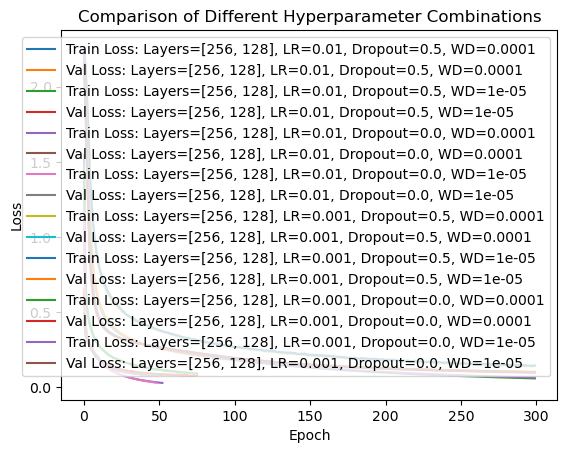

In [24]:
# Define the ExperimentNN class with Dropout
class ExperimentNN(nn.Module):
    def __init__(self, layers, dropout):
        super(ExperimentNN, self).__init__()
        self.layers = nn.ModuleList()
        input_size = 28 * 28
        for layer_size in layers:
            self.layers.append(nn.Linear(input_size, layer_size))
            input_size = layer_size
        self.output = nn.Linear(input_size, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(-1, 28*28)
        for layer in self.layers:
            x = torch.relu(layer(x))
            x = self.dropout(x)  # Apply dropout after each layer
        x = self.output(x)
        return x

# Split trainset into training and validation sets
train_indices, val_indices = train_test_split(range(len(trainset)), test_size=0.2, random_state=42)
train_subset = torch.utils.data.Subset(trainset, train_indices)
val_subset = torch.utils.data.Subset(trainset, val_indices)

# Define DataLoaders for training, validation, and test sets
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Define hyperparameter options
num_epochs = 300
layer_options = [[256, 128]]
learning_rate_options = [0.01, 0.001]
dropout_options = [0.5, 0.0]
weight_decay_options = [1e-4, 1e-5]

# Generate all combinations of hyperparameters
hyperparameter_combinations = list(product(layer_options, learning_rate_options, dropout_options, weight_decay_options))

results = {}

# Loop through all hyperparameter combinations
for layers, learning_rate, dropout, weight_decay in hyperparameter_combinations:
    model = ExperimentNN(layers, dropout).to(device)
    
    # Use SGD optimizer with L2 Regularization (weight_decay)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 5  # Number of epochs to wait before early stopping
    trigger_times = 0
    
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        # Evaluate on validation data
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(valloader)
        val_losses.append(avg_val_loss)

        print(f'Layers: {layers}, LR: {learning_rate}, Dropout: {dropout}, Weight Decay: {weight_decay}, Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            
        if trigger_times >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break
    
    # Store results
    results[(str(layers), learning_rate, dropout, weight_decay)] = (train_losses, val_losses)

# Evaluate the best model on the test set
for params, (train_losses, val_losses) in results.items():
    model = ExperimentNN(eval(params[0]), params[2]).to(device)
    optimizer = optim.SGD(model.parameters(), lr=params[1], weight_decay=params[3])
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / len(testloader)
    accuracy = 100 * correct / len(testset)
    print(f'Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Plotting the results for comparison
for params, (train_losses, val_losses) in results.items():
    layers, lr, dropout, weight_decay = params
    plt.plot(train_losses, label=f'Train Loss: Layers={layers}, LR={lr}, Dropout={dropout}, WD={weight_decay}')
    plt.plot(val_losses, label=f'Val Loss: Layers={layers}, LR={lr}, Dropout={dropout}, WD={weight_decay}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparison of Different Hyperparameter Combinations')
plt.show()
